# Face Mask Solution

## Introduction

Face masks have become an essential tool in preventing the spread of airborne diseases, protecting individuals from pollutants, and ensuring safety in various environments. The need for an effective, comfortable, and sustainable face mask solution has driven advancements in materials, design, and filtration technology.

This notebook presents a comprehensive guide to how to build a deep learning-based face mask detection system using Convolutional Neural Networks (CNNs). It covers the entire workflow, from data preprocessing and visualization to model training, evaluation, and real-time prediction. You will gain hands-on experience in image classification, dataset handling, model performance analysis, and deployment of AI models. By the end, you will understand how to train a neural network to distinguish between masked and unmasked faces, assess model accuracy, and apply this knowledge to real-world applications in computer vision.

**Note** I'm running this notebook in google colab with T4 GPU, since it'll take too much time to build the model in you're local system

## Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Required Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

## Now we loads and processes the dataset of face mask images stored in a ZIP file.</br>
Below code extracts images from the ZIP, categorizes them into "with mask" (label=1) and "without mask" (label=0) based on their file paths, and resizes them to 128x128 pixels for compatibility with a CNN model. Each image is converted to an array, normalized (pixel values scaled between 0 and 1), and stored in X_data, while corresponding labels are stored in Y_labels. Additionally, images are separately stored for visualization. Finally, the dataset is converted into NumPy arrays and the total image count is printed.

In [ ]:
# Define the path to the ZIP file
zip_file_path = "/content/drive/MyDrive/Face_Mask_Detection/Face_mask_data.zip"  # Change to your ZIP file path

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()  # List of files inside ZIP

    # Initialize lists for images and labels
    X_data = []
    Y_labels = []
    mask_images = []  # Store images of people wearing masks
    no_mask_images = []  # Store images of people without masks

    # Loop through images inside "data/with_mask/" and "data/without_mask/"
    for image_file in file_list:
        if image_file.startswith("data/with_mask/") and image_file.endswith(('.png', '.jpg', '.jpeg')):
            label = 1  # Mask
        elif image_file.startswith("data/without_mask/") and image_file.endswith(('.png', '.jpg', '.jpeg')):
            label = 0  # No Mask
        else:
            continue  # Skip non-image files

        # Read image from ZIP
        with zip_ref.open(image_file) as file:
            image = Image.open(io.BytesIO(file.read())).convert("RGB")
            image = image.resize((128, 128))  # Resize to match CNN input
            image_array = img_to_array(image) / 255.0  # Normalize pixels
            X_data.append(image_array)
            Y_labels.append(label)

            # Store separately for visualization
            if label == 1:
                mask_images.append(image_array)
            else:
                no_mask_images.append(image_array)

# Convert lists to NumPy arrays
X_data = np.array(X_data)
Y_labels = np.array(Y_labels)

print(f"Dataset Loaded: {X_data.shape[0]} images found.")
print(f"With Mask Images: {len(mask_images)}")
print(f"Without Mask Images: {len(no_mask_images)}")

Dataset Loaded: 7553 images found.
With Mask Images: 3725
Without Mask Images: 3828


- We see there are total 7553 images and it's not imbalance dataset

## Visualizing the Dataset
To inspect the dataset, we randomly select and display sample images from both the "with mask" and "without mask" categories. Up to six images are chosen from each category to ensure diversity. Using Matplotlib, the images are plotted in a 2-row, 3-column layout, with appropriate labels ("Mask" or "No Mask").

In [ ]:
import random
# Select random samples to display
random_mask_samples = random.sample(mask_images, min(6, len(mask_images)))
random_no_mask_samples = random.sample(no_mask_images, min(6, len(no_mask_images)))

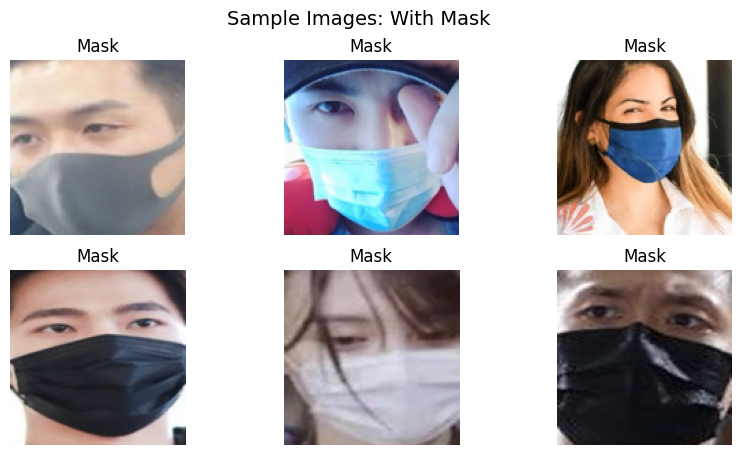

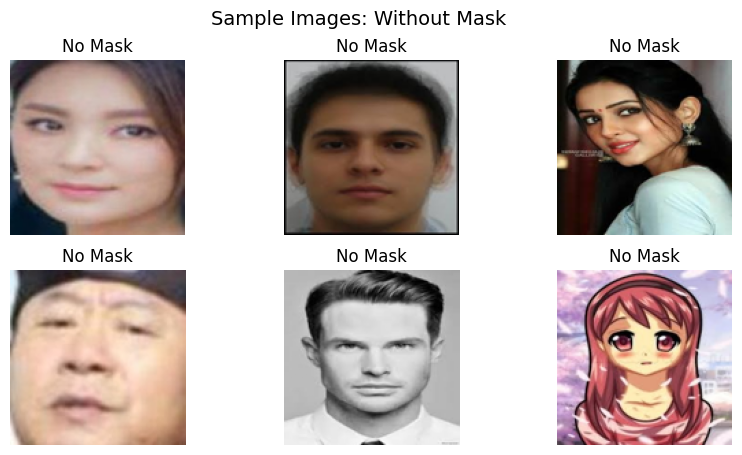

In [ ]:
# Display "With Mask" images
plt.figure(figsize=(10, 5))
for i, img in enumerate(random_mask_samples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title("Mask")
    plt.axis("off")
plt.suptitle("Sample Images: With Mask", fontsize=14)
plt.show()

# Display "Without Mask" images
plt.figure(figsize=(10, 5))
for i, img in enumerate(random_no_mask_samples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title("No Mask")
    plt.axis("off")
plt.suptitle("Sample Images: Without Mask", fontsize=14)
plt.show()

## Split the data for model building
Now we splits the dataset into training and validation sets, ensuring that 80% of the images are used for training (X_train, Y_train) and 20% for validation (X_val, Y_val).

In [ ]:
# Split data into 80% Training and 20% Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_labels, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape[0]} images")
print(f"Validation Data: {X_val.shape[0]} images")

Training Data: 6042 images
Validation Data: 1511 images


## Checking GPU Availability for Model Training
This code checks whether a GPU is available for accelerating deep learning computations using TensorFlow. If a GPU is detected, the system prints "GPU is available", allowing the model to leverage GPU processing power for faster training. If no GPU is found, the script forces execution on the CPU by setting "CUDA_VISIBLE_DEVICES" = "-1", ensuring TensorFlow does not attempt to use an unavailable GPU.

In [ ]:
import os
import tensorflow as tf

# Check GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU not found, forcing CPU execution")
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

GPU is available


## Building and Training a CNN Model for Face Mask Detection
This code defines, compiles, and trains a Convolutional Neural Network (CNN) for face mask detection using TensorFlow’s keras.Sequential API. The model consists of:
- Two Convolutional Layers (Conv2D) with ReLU activation for feature extraction.
- MaxPooling Layers (MaxPooling2D) to reduce spatial dimensions and computational cost.
- Flatten Layer to convert the feature maps into a one-dimensional vector.
- Dense Layer with 128 neurons and ReLU activation for deeper feature learning.
- Output Layer with a sigmoid activation for binary classification (mask vs. no mask).

The model is compiled using:
- Adam optimizer for efficient learning.
- Binary cross-entropy loss function (since it's a binary classification task).
- Accuracy metric to track performance.

Finally, the model is trained for 10 epochs using the fit() function with a batch size of 32, leveraging training data (X_train, Y_train) and validation data (X_val, Y_val) to monitor its performance.

In [ ]:
from tensorflow import keras
# Define CNN Model for Face Mask Detection
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model with validation data
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7393 - loss: 0.8825 - val_accuracy: 0.8948 - val_loss: 0.2542
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8996 - loss: 0.2488 - val_accuracy: 0.8676 - val_loss: 0.3025
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9270 - loss: 0.1799 - val_accuracy: 0.9259 - val_loss: 0.1917
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9517 - loss: 0.1152 - val_accuracy: 0.8855 - val_loss: 0.2831
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9631 - loss: 0.0980 - val_accuracy: 0.9252 - val_loss: 0.2376
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9820 - loss: 0.0546 - val_accuracy: 0.9404 - val_loss: 0.2635
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9807 - loss: 0.0540 - val_accuracy: 0.9338 - val_loss: 0.2682
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9869 - loss: 0.0362 - val_acc

## Evaluating the Model on Validation Data
This code evaluates the trained CNN model's performance on the validation dataset (X_val, Y_val) using the evaluate() function. It computes:
- Validation Loss (val_loss) – Measures how well the model predicts compared to the actual labels.
- Validation Accuracy (val_accuracy) – Represents the percentage of correctly classified images.

The results are printed, displaying the validation accuracy (%) and validation loss with appropriate formatting. This step helps determine whether the model is generalizing well to unseen data or if it is overfitting to the training set.

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=1)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9146 - loss: 0.4006
Validation Accuracy: 91.93%
Validation Loss: 0.3662


## Visualizing Model Performance: Accuracy and Loss
This code plots the training and validation accuracy as well as training and validation loss over epochs to assess model performance.
Training vs. Validation Accuracy Plot:
- Displays how the model's accuracy improves over time for both training and validation sets.
- Helps identify overfitting (if validation accuracy stops improving while training accuracy continues increasing).

Training vs. Validation Loss Plot:
- Shows how the model’s loss decreases over epochs.
- Helps determine if the model is underfitting (high training loss) or overfitting (validation loss increases while training loss keeps decreasing).

These visualizations provide insights into the learning behavior of the CNN model, guiding potential improvements like hyperparameter tuning or data augmentation.

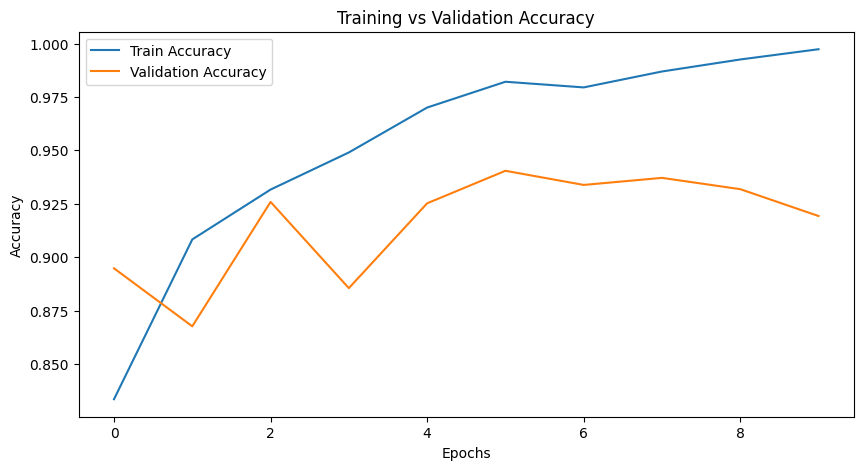

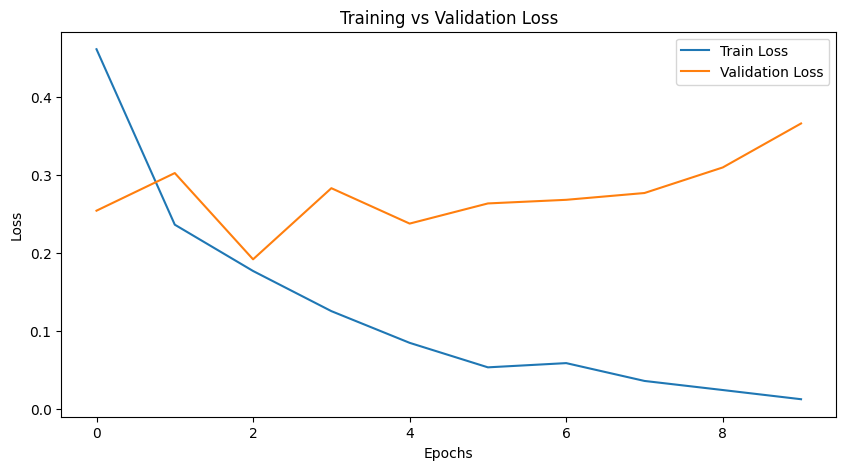

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Evaluating Model Performance with Classification Report and Confusion Matrix
This code analyzes the model’s performance on the validation set using classification metrics and a confusion matrix.

Making Predictions:
- The trained model predicts probabilities for the validation images.
- These probabilities are converted into binary labels (1 = Mask, 0 = No Mask) based on a threshold of 0.5.

Classification Report:
- Uses classification_report() to provide detailed metrics:
- Precision: How many predicted mask/no-mask cases are correct.
- Recall: How well the model identifies actual mask/no-mask cases.
- F1-score: Balance between precision and recall.
- Support: Number of actual occurrences for each class.

Confusion Matrix:
- Creates a heatmap visualization to compare actual vs. predicted labels.

The matrix helps identify:
- True Positives (TP) – Correct mask predictions.
- True Negatives (TN) – Correct no-mask predictions.
- False Positives (FP) – Incorrectly predicted mask cases.
- False Negatives (FN) – Incorrectly predicted no-mask cases.

This step helps assess model reliability and misclassification trends, guiding further improvements such as data balancing or model tuning.

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       750
           1       0.92      0.91      0.92       761

    accuracy                           0.92      1511
   macro avg       0.92      0.92      0.92      1511
weighted avg       0.92      0.92      0.92      1511



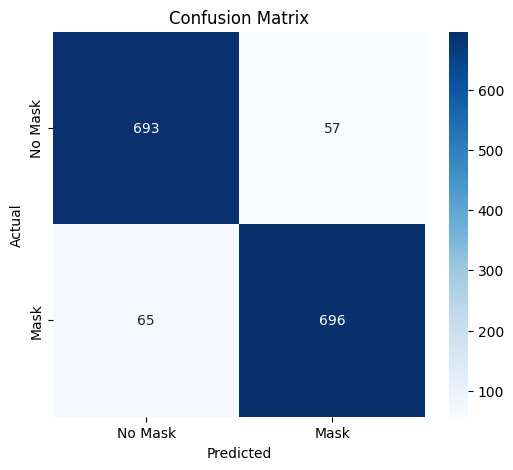

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions on validation set
predictions = model.predict(X_val)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32")

# Classification report
print("Classification Report:\n", classification_report(Y_val, predicted_labels))

# Confusion matrix
cm = confusion_matrix(Y_val, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Saving the Trained Model
This code saves the trained face mask detection model using TensorFlow's Keras format (.keras):
- This ensures that the trained model, including its architecture, weights, and training configuration, is stored for future use.
- The saved model can be reloaded later for inference or further training without retraining from scratch.
- It can be deployed in real-world applications, such as mobile apps, embedded systems, or cloud-based AI services.

This step is crucial for model preservation and deployment in face mask detection applications.

In [ ]:
model.save("/content/drive/MyDrive/Face_Mask_Detection/face_mask_detector.keras")

## Loading the Saved Face Mask Detection Model
This code loads the previously saved model using Keras:
- It restores the entire model, including its architecture, trained weights, and optimizer settings.
- This allows the model to be used for making predictions or further fine-tuning without retraining from scratch.
- The loaded model can be deployed in real-world applications such as real-time face mask detection systems.
This step making it easy to integrate into applications or perform additional testing.

In [ ]:
load_model = keras.models.load_model("/content/drive/MyDrive/Face_Mask_Detection/face_mask_detector.keras")

## Performing Face Mask Detection on a New Image
This code loads a trained face mask detection model and predicts whether a person in a given image is wearing a mask.
## Key Steps:
- Load the Pretrained Model
- Preprocess the Input Image (preprocess_image function):
    - Checks if the image exists.
    - Reads the image using OpenCV (cv2.imread).
    - Converts the image from BGR to RGB (since OpenCV loads images in BGR format).
    - Resizes it to 128x128 pixels to match the model’s input shape.
    - Normalizes pixel values to a range of 0-1.
    - Expands dimensions to make it compatible with the CNN model.
## Perform Prediction:
- If the image exists, it is preprocessed and fed into the model.
- The model predicts the probability of wearing a mask.
- If the probability is ≥ 0.5, the result is "Mask Detected ✅", otherwise "No Mask Detected ❌".
## Display the Image with Prediction Result:
- Loads the original image and displays it using matplotlib.pyplot.
- The title of the image shows the detection result.

I've used new image to test the model you can use different images to test the model performence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


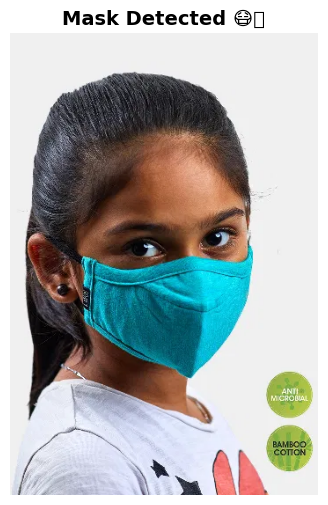

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow import keras

# Load the trained model
model = keras.models.load_model("/content/drive/MyDrive/Face_Mask_Detection/face_mask_detector.keras")

# Function to preprocess a new image
def preprocess_image(image_path):

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Error: Image file not found at {image_path}")

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB
    img = cv2.resize(img, (128, 128))  # Resize to match model input
    img = img / 255.0  # Normalize pixel values (0-1)
    img = np.expand_dims(img, axis=0)  # Expand dimensions for model input
    return img

# Path to the new image
image_path = "/content/drive/MyDrive/Face_Mask_Detection/test_image.webp"  # Change this to your actual image path

# Predict only if the image exists
if os.path.exists(image_path):
    input_img = preprocess_image(image_path)

    # Perform prediction
    prediction = model.predict(input_img)

    # Interpret the result
    result_text = "No Mask Detected 😷❌" if prediction[0][0] < 0.5 else "Mask Detected 😷✅"

    # Load the original image for display
    img_display = cv2.imread(image_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Display the image with the prediction result
    plt.figure(figsize=(6,6))
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(result_text, fontsize=14, fontweight="bold")
    plt.show()
else:
    print(f"Error: Image file not found at {image_path}")